## LEAKY INTEGRATE AND FIRE

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import gridspec
import random

In [3]:
dt = 0.05
max_t = 10
init_t = 0.0
start_time = 1.0
stop_time = 6.0
cap = 1
res = 2
threshold = 3.0
spike_display = 8.0
init_v = 0.0
voltage = init_v
tau = res * cap
eL = 0
gL = tau

In [4]:
def update(old_value, roc, time_step):
    return ((roc * time_step) + old_value)

def dv_dt(localres, locali, localv):
    return locali - localv/localres

def voltage_choise(curr_volt, spike_status, thr, sd):
    if (curr_volt > thr) and (not spike_status):
        spike_status = True
        return sd, spike_status
    elif (curr_volt > thr) and spike_status:
        spike_status = False
        return 0.0, spike_status
    elif (curr_volt < thr) and spike_status:
        spike_status = False
        return curr_volt, spike_status
    elif (curr_volt < thr) and (not spike_status):
        spike_status = False
        return curr_volt, spike_status

In [5]:
def run_iandf_sim():
    random.seed(4)
    time = []
    V = []
    I=[]
    spike_status = False
    
    for idt in range(int(max_t/dt)):
        noise = round(random.uniform(1.33, 1.66), 2)
        time.append(dt*idt)
        if time[idt] <= start_time or time[idt] >= stop_time:
            I.append(0)
            if idt == 0:
                dv = dv_dt(res, I[idt], init_v)
                v_now = update(init_v, dv, dt)
            else:
                dv = dv_dt(res, I[idt], V[idt-1])
                v_now = update(V[idt-1], dv, dt)
            v_now, spike_status = voltage_choise(v_now, spike_status, threshold, spike_display)
            V.append(v_now)
        if time[idt] > start_time and time[idt] < stop_time:
            I.append(noise)
            dv = dv_dt(res, I[idt], V[idt-1])
            v_now = update(V[idt-1], dv, dt)
            v_now, spike_status = voltage_choise(v_now, spike_status, threshold, spike_display)
            V.append(v_now)
           

    return V, I, time

v, i, t = run_iandf_sim()

In [6]:
v, i, t = run_iandf_sim()

Text(0.5, 0, 'Time (msec.)')

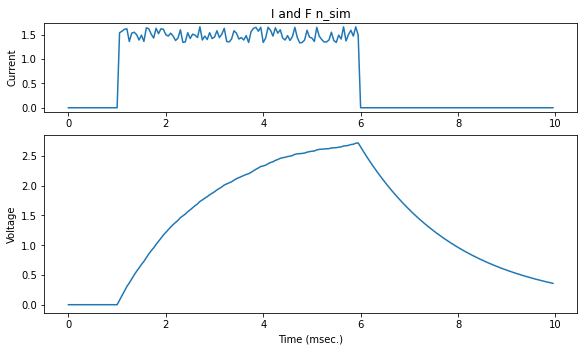

In [7]:
fig = plt.figure(figsize=(8, 6), constrained_layout=True)
spec = fig.add_gridspec(4, 4)
ax0 = fig.add_subplot(spec[0, :])
ax0.plot(t, i)
ax0.set_ylabel("Current")
ax10 = fig.add_subplot(spec[1:3, :], sharex = ax0)
ax0.set_title("I and F n_sim")
ax10.plot(t, v)
ax10.set_ylabel("Voltage")
ax10.set_xlabel("Time (msec.)")



## Imbalanced Threshold

\begin{cases}
    \ 1,& \text{if } V_m\geq V_{th},_{pos}(V_{th})\\
     -1,& \text{if } V_m\leq V_{th},_{neg}(-\frac{1}{\alpha}V_{th})\\
     0,& \text{otherwise, no firing}
\end{cases}


## **snntorch** package for creating a Spiking Neural Network

In [2]:
import torch, torch.nn as nn
import snntorch as snn
import numpy as np
import random as r

In [2]:
import torch


def batched_dot_mul_sum(a, b):
    '''Computes batched dot by multiplying and summing'''
    return a.mul(b).sum(-1)


def batched_dot_bmm(a, b):
    '''Computes batched dot by reducing to bmm'''
    a = a.reshape(-1, 1, a.shape[-1])
    b = b.reshape(-1, b.shape[-1], 1)
    return torch.bmm(a, b).flatten(-3)


# Input for benchmarking
x = torch.randn(10000, 64)

# Ensure that both functions compute the same output
assert batched_dot_mul_sum(x, x).allclose(batched_dot_bmm(x, x))

In [3]:
import timeit

t0 = timeit.Timer(
    stmt='batched_dot_mul_sum(x, x)',
    setup='from __main__ import batched_dot_mul_sum',
    globals={'x': x})

t1 = timeit.Timer(
    stmt='batched_dot_bmm(x, x)',
    setup='from __main__ import batched_dot_bmm',
    globals={'x': x})

print(f'mul_sum(x, x):  {t0.timeit(100) / 100 * 1e6:>5.1f} us')
print(f'bmm(x, x):      {t1.timeit(100) / 100 * 1e6:>5.1f} us')

x = torch.randn(10000, 1024, device='cuda')

t0 = timeit.Timer(
    stmt='batched_dot_mul_sum(x, x)',
    setup='from __main__ import batched_dot_mul_sum',
    globals={'x': x})

t1 = timeit.Timer(
    stmt='batched_dot_bmm(x, x)',
    setup='from __main__ import batched_dot_bmm',
    globals={'x': x})

# Ran each twice to show difference before/after warmup
print(f'mul_sum(x, x):  {t0.timeit(100) / 100 * 1e6:>5.1f} us')
print(f'mul_sum(x, x):  {t0.timeit(100) / 100 * 1e6:>5.1f} us')
print(f'bmm(x, x):      {t1.timeit(100) / 100 * 1e6:>5.1f} us')
print(f'bmm(x, x):      {t1.timeit(100) / 100 * 1e6:>5.1f} us')

mul_sum(x, x):   58.1 us
bmm(x, x):       75.6 us
mul_sum(x, x):   28.7 us
mul_sum(x, x):    8.4 us
bmm(x, x):      15898.2 us
bmm(x, x):       27.6 us


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)


#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')



Using device: cuda
NVIDIA GeForce RTX 3080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.4 GB


In [3]:
from pathlib import Path
from tqdm import tqdm
import numpy as np
import json
import urllib
import PIL.Image as Image
import cv2
import torch
import torchvision
from IPython.display import display
from sklearn.model_selection import train_test_split

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 16, 10

np.random.seed(42)

In [7]:
train_clothing, val_clothing = train_test_split(clothing, test_size=0.1)
len(train_clothing), len(val_clothing)
(453, 51)

NameError: name 'clothing' is not defined

In [6]:
row = train_clothing[10]

img = urllib.request.urlopen(row["content"])
img = Image.open(img)
img = img.convert('RGB')

img.save("demo_image.jpeg", "JPEG")

NameError: name 'train_clothing' is not defined

In [4]:
img = cv2.cvtColor(cv2.imread(f'demo_image.jpeg'), cv2.COLOR_BGR2RGB)
img.shape
(312, 145, 3)

error: OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [ ]:
for a in row['annotation']:
 for label in a['label']:

   w = a['imageWidth']
   h = a['imageHeight']

   points = a['points']
   p1, p2 = points

    x1, y1 = p1['x'] * w, p1['y'] * h
    x2, y2 = p2['x'] * w, p2['y'] * h

    cv2.rectangle(
      img,
      (int(x1), int(y1)),
      (int(x2), int(y2)),
      color=(0, 255, 0),
      thickness=2
    )

    ((label_width, label_height), _) = cv2.getTextSize(
        label,
        fontFace=cv2.FONT_HERSHEY_PLAIN,
        fontScale=1.75,
        thickness=2
    )

    cv2.rectangle(
      img,
      (int(x1), int(y1)),
      (int(x1 + label_width + label_width * 0.05), int(y1 + label_height + label_height * 0.25)),
      color=(0, 255, 0),
      thickness=cv2.FILLED
    )

    cv2.putText(
      img,
      label,
      org=(int(x1), int(y1 + label_height + label_height * 0.25)), # bottom left
      fontFace=cv2.FONT_HERSHEY_PLAIN,
      fontScale=1.75,
      color=(255, 255, 255),
      thickness=2
    )